In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

len(X_train)

7332

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

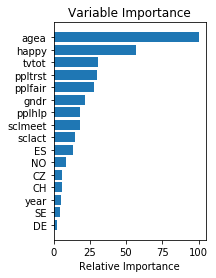

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [5]:
param_test1 = [{'n_estimators':[20, 40, 60, 80, 100], 'learning_rate':[0.001, 0.05, 0.1, 0.15, 0.2]}]
clf = ensemble.GradientBoostingClassifier(**params)
gsearch1 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(min_samples_split=10,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10, 
                                                               loss='deviance'), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch1.fit(X_train,y_train)
print(gsearch1.grid_scores_, '\n', gsearch1.best_params_, '\n', gsearch1.best_score_)

[mean: 0.77373, std: 0.01512, params: {'learning_rate': 0.001, 'n_estimators': 20}, mean: 0.77699, std: 0.01776, params: {'learning_rate': 0.001, 'n_estimators': 40}, mean: 0.77816, std: 0.01802, params: {'learning_rate': 0.001, 'n_estimators': 60}, mean: 0.77899, std: 0.01887, params: {'learning_rate': 0.001, 'n_estimators': 80}, mean: 0.77942, std: 0.01845, params: {'learning_rate': 0.001, 'n_estimators': 100}, mean: 0.77904, std: 0.01864, params: {'learning_rate': 0.05, 'n_estimators': 20}, mean: 0.78495, std: 0.01967, params: {'learning_rate': 0.05, 'n_estimators': 40}, mean: 0.78576, std: 0.01972, params: {'learning_rate': 0.05, 'n_estimators': 60}, mean: 0.78687, std: 0.01947, params: {'learning_rate': 0.05, 'n_estimators': 80}, mean: 0.78603, std: 0.01866, params: {'learning_rate': 0.05, 'n_estimators': 100}, mean: 0.78212, std: 0.01747, params: {'learning_rate': 0.1, 'n_estimators': 20}, mean: 0.78430, std: 0.01812, params: {'learning_rate': 0.1, 'n_estimators': 40}, mean: 0.78

A grid search to explore the trade-off between the learning rate and the number of estimators yielded optimal parameters of 0.05 and 80. Let's fit a model with those parameters and see how it fares in cross-validation on the tuning dataset.

In [6]:
clf1 = ensemble.GradientBoostingClassifier(learning_rate=0.05, 
                                           min_samples_split=10,
                                           min_samples_leaf=50,
                                           n_estimators=80,
                                           max_depth=8,
                                           max_features='sqrt',
                                           subsample=0.8,
                                           random_state=10,
                                           loss='deviance')

clf1.fit(X_train,y_train)
predict_train = clf1.predict(X_train)

print(cross_val_score(clf1, X_train, y_train, cv=5))
print(cross_val_score(clf1, X_train, y_train, cv=5).mean())

# Accuracy tables.
print(classification_report(y_train, predict_train))
table_train = pd.crosstab(y_train, predict_train, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

[ 0.77232447  0.71574642  0.7607362   0.74079127  0.76109215]
0.750138101645
             precision    recall  f1-score   support

        0.0       0.77      0.94      0.84      4508
        1.0       0.84      0.54      0.66      2824

avg / total       0.80      0.78      0.77      7332

Training set accuracy:
Percent Type I errors: 0.039416257501363884
Percent Type II errors: 0.1756683033278778




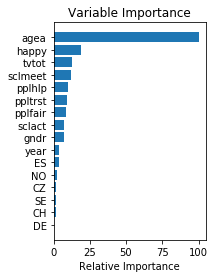

In [7]:
feature_importance = clf1.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

We have a somewhat consistent accuracy rating of 75% in the training data, and that the Type I error rates for the training data dropped a tiny bit with the optimized parameters. We can also see that age is disproportionately important in this model, as compared to the untuned model above. 

Let's try some of the parameters related to the estimators and see if we can improve the model.

In [8]:
param_test2 = [{'min_samples_split':[10, 50, 100, 200, 400], 'max_depth':[4,8,16,24]}]
clf = ensemble.GradientBoostingClassifier(**params)
gsearch2 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.05,
                                                                        n_estimators=80,
                                                                        min_samples_leaf=50,
                                                                        max_features='sqrt',
                                                                        subsample=0.8,
                                                                        random_state=10), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch2.fit(X_train,y_train)
print(gsearch2.grid_scores_, '\n', gsearch2.best_params_, '\n', gsearch2.best_score_)

[mean: 0.78382, std: 0.01966, params: {'max_depth': 4, 'min_samples_split': 10}, mean: 0.78382, std: 0.01966, params: {'max_depth': 4, 'min_samples_split': 50}, mean: 0.78382, std: 0.01966, params: {'max_depth': 4, 'min_samples_split': 100}, mean: 0.78404, std: 0.02044, params: {'max_depth': 4, 'min_samples_split': 200}, mean: 0.78469, std: 0.01941, params: {'max_depth': 4, 'min_samples_split': 400}, mean: 0.78687, std: 0.01947, params: {'max_depth': 8, 'min_samples_split': 10}, mean: 0.78687, std: 0.01947, params: {'max_depth': 8, 'min_samples_split': 50}, mean: 0.78687, std: 0.01947, params: {'max_depth': 8, 'min_samples_split': 100}, mean: 0.78646, std: 0.02025, params: {'max_depth': 8, 'min_samples_split': 200}, mean: 0.78529, std: 0.01866, params: {'max_depth': 8, 'min_samples_split': 400}, mean: 0.78475, std: 0.02017, params: {'max_depth': 16, 'min_samples_split': 10}, mean: 0.78475, std: 0.02017, params: {'max_depth': 16, 'min_samples_split': 50}, mean: 0.78475, std: 0.02017, pa

The optimal values for max_depth and min_samples_split are in fact the ones we used as baselines in our initial model. 

In [9]:
param_test3 = [{'subsample':[0.7, 0.8, 0.9], 'max_features':['sqrt','log2']}]
clf = ensemble.GradientBoostingClassifier(**params)
gsearch3 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.05,
                                                                        n_estimators=80,
                                                                        min_samples_split=10,
                                                                        max_depth=8,
                                                                        min_samples_leaf=50,
                                                                        random_state=10), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch3.fit(X_train,y_train)
print(gsearch3.grid_scores_, '\n', gsearch3.best_params_, '\n', gsearch3.best_score_)

[mean: 0.78517, std: 0.02080, params: {'max_features': 'sqrt', 'subsample': 0.7}, mean: 0.78687, std: 0.01947, params: {'max_features': 'sqrt', 'subsample': 0.8}, mean: 0.78330, std: 0.01935, params: {'max_features': 'sqrt', 'subsample': 0.9}, mean: 0.78517, std: 0.02080, params: {'max_features': 'log2', 'subsample': 0.7}, mean: 0.78687, std: 0.01947, params: {'max_features': 'log2', 'subsample': 0.8}, mean: 0.78330, std: 0.01935, params: {'max_features': 'log2', 'subsample': 0.9}] 
 {'max_features': 'sqrt', 'subsample': 0.8} 
 0.7868668223776023


Once again, our original hyperparameters turn out to be the opitmal ones. 

For a final tuning procedure, we'll run the model with the exponential loss function in place of deviance. 

In [10]:
clf4 = ensemble.GradientBoostingClassifier(learning_rate=0.05, 
                                           min_samples_split=10,
                                           min_samples_leaf=50,
                                           n_estimators=80,
                                           max_depth=8,
                                           max_features='sqrt',
                                           subsample=0.8,
                                           random_state=10,
                                           loss='exponential')

clf4.fit(X_train,y_train)
predict_train = clf4.predict(X_train)

print(cross_val_score(clf4, X_train, y_train, cv=5))
print(cross_val_score(clf4, X_train, y_train, cv=5).mean())

# Accuracy tables.
print(classification_report(y_train, predict_train))
table_train = pd.crosstab(y_train, predict_train, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

[ 0.77300613  0.72460804  0.76346285  0.73942701  0.74948805]
0.749998418967
             precision    recall  f1-score   support

        0.0       0.76      0.94      0.84      4508
        1.0       0.85      0.54      0.66      2824

avg / total       0.80      0.78      0.77      7332

Training set accuracy:
Percent Type I errors: 0.03737043098745226
Percent Type II errors: 0.1778505182760502




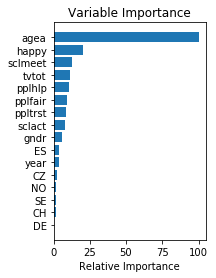

In [11]:
feature_importance = clf4.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Here again, the Type I error rate improves, while the Type II error rate gets a little bit worse. Models 1 and 4 offer different advantages, depending on whether we are more concerned with the precision or recall. Let's run both on our test data, to see how well they perform.

In [12]:
predict_test = clf1.predict(X_test)

#Accuracy tables.
print(classification_report(y_test, predict_test))
table_test = pd.crosstab(y_test, predict_test, margins=True)
test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.75      0.89      0.82       505
        1.0       0.75      0.52      0.61       310

avg / total       0.75      0.75      0.74       815

Test set accuracy:
Percent Type I errors: 0.06625766871165645
Percent Type II errors: 0.18282208588957055




In [13]:
predict_test = clf4.predict(X_test)

#Accuracy tables.
print(classification_report(y_test, predict_test))
table_test = pd.crosstab(y_test, predict_test, margins=True)
test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.75      0.89      0.81       505
        1.0       0.75      0.51      0.61       310

avg / total       0.75      0.75      0.73       815

Test set accuracy:
Percent Type I errors: 0.06625766871165645
Percent Type II errors: 0.18650306748466258




Their performance is nearly identical, but Model 1 has a slight advantage over Model 4 with respect to Type II error rate, so it is our best performer.